# 1. Notebook Setup

Import libraries

In [19]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import gc
from math import sqrt
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

sys.path.append("/home/jovyan/Solar-Irradiance-Forecasting/src/")
import eda as eda
import helpers as hlp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup notebook

In [ ]:
# Random seed generators
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format ="retina"  # High quality plots

# Pandas df display
pd.options.display.float_format = '{:,.2f}'.format  # Choose how many decimals to show for floats in df tables
pd.options.mode.chained_assignment = None  # default="warn"
pd.set_option("display.max_rows", 1000, "display.max_columns", 1000)  # Print more rows & columns
pd.set_option("display.float_format", lambda x: "%.3f" % x)  # Avoid scientific notation

Use GPU

In [2]:
print("Available devices: ", tf.config.experimental.list_physical_devices())

physical_gpu = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_gpu))
print("Device details: ", tf.config.experimental.get_device_details(physical_gpu[0]))
tf.config.experimental.set_memory_growth(physical_gpu[0], True)

Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Device details:  {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


2023-09-04 20:38:28.797338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 20:38:28.809970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 20:38:28.810592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 20:38:28.812261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 2. Loading and merging data

Load target

In [3]:
df_irradiance = pd.read_csv("../../data/Folsom_irradiance.csv", infer_datetime_format=True)
df_irradiance["timeStamp"] = pd.to_datetime(df_irradiance["timeStamp"])
df_irradiance = df_irradiance[["timeStamp", "ghi"]]
df_irradiance

,timeStamp,ghi
0,2014-01-02 08:00:00,0.0
1,2014-01-02 08:01:00,0.0
2,2014-01-02 08:02:00,0.0
3,2014-01-02 08:03:00,0.0
4,2014-01-02 08:04:00,0.0
...,...,...
1552315,2016-12-31 07:55:00,0.0
1552316,2016-12-31 07:56:00,0.0
1552317,2016-12-31 07:57:00,0.0
1552318,2016-12-31 07:58:00,0.0


Load weather data

In [4]:
df_weather = pd.read_csv("../../data/Folsom_weather.csv", infer_datetime_format=True)
df_weather["timeStamp"] = pd.to_datetime(df_weather["timeStamp"])
df_irradiance

,timeStamp,ghi
0,2014-01-02 08:00:00,0.0
1,2014-01-02 08:01:00,0.0
2,2014-01-02 08:02:00,0.0
3,2014-01-02 08:03:00,0.0
4,2014-01-02 08:04:00,0.0
...,...,...
1552315,2016-12-31 07:55:00,0.0
1552316,2016-12-31 07:56:00,0.0
1552317,2016-12-31 07:57:00,0.0
1552318,2016-12-31 07:58:00,0.0


Merge both datasets

In [5]:
df = df_irradiance.merge(df_weather, 
                         on="timeStamp", 
                         how="left", 
                         indicator=True)
display(df)
display(df["_merge"].value_counts())
df = df.drop(columns=["_merge"])

,timeStamp,ghi,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,_merge
0,2014-01-02 08:00:00,0.0,7.32,56.56,1010.0,1.80,43.61,3.7,0.0,both
1,2014-01-02 08:01:00,0.0,7.26,56.82,1010.0,2.00,48.40,3.1,0.0,both
2,2014-01-02 08:02:00,0.0,7.20,56.96,1010.0,1.90,31.80,3.7,0.0,both
3,2014-01-02 08:03:00,0.0,7.14,57.12,1010.0,1.44,38.98,2.5,0.0,both
4,2014-01-02 08:04:00,0.0,7.08,57.36,1010.0,1.84,34.21,2.8,0.0,both
...,...,...,...,...,...,...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,7.60,85.60,1001.0,1.28,237.10,2.2,0.0,both
1552316,2016-12-31 07:56:00,0.0,7.60,85.80,1000.0,3.46,171.20,6.8,0.0,both
1552317,2016-12-31 07:57:00,0.0,7.70,86.10,1001.0,1.38,213.20,2.8,0.0,both
1552318,2016-12-31 07:58:00,0.0,7.70,86.10,1001.0,1.44,168.50,2.4,0.0,both


both          1552320
left_only           0
right_only          0
Name: _merge, dtype: int64

In [6]:
del df_irradiance
del df_weather
gc.collect()

517

# 3. Data Preprocessing

In [ ]:
# Define the number of time steps to use for input sequences
n_steps = 20 
features = ['air_temp', 'relhum', 'press', 'windsp', 'winddir', 'max_windsp', 'precipitation']

def prepare_data(df, n_steps_20min):
    # Create lagged features for the past 20 minutes using pandas shift
    for i in range(1, n_steps_20min + 1):
        for col in features:
            df[f'{col}_lag_{i}m'] = df[col].shift(i)
    
    # Drop rows with missing values (NaN)
    df = df.dropna()

    return df

df_fe = prepare_data(df, n_steps)

/tmp/ipykernel_7995/1537709175.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}m'] = df[col].shift(i)
/tmp/ipykernel_7995/1537709175.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}m'] = df[col].shift(i)
/tmp/ipykernel_7995/1537709175.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [8]:
del df
gc.collect()

1442

Train/Validation/Test split

In [9]:
train_start = "2014-01-01"
validation_start = "2015-01-01"
test_start = "2016-01-01"

df_train = df_fe.loc[df_fe["timeStamp"] < validation_start]
df_validation = df_fe.loc[(df_fe["timeStamp"] >= validation_start) & (df_fe["timeStamp"] < test_start)]
df_test = df_fe.loc[df_fe["timeStamp"] >= test_start]

X_train, X_val, X_test = df_train[features], df_validation[features], df_test[features]
y_train, y_val, y_test = df_train["ghi"], df_validation["ghi"], df_test["ghi"]

Normalize input data (scaling between 0 and 1)

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

Reshape the input data for LSTM (3D shape)

In [28]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 4. Model

In [ ]:
MODEL_VERSION = "2"

Define the LSTM model.

To fine-tune:
- number of nodes (25, 50, 75, 100, 125, 150)
- optimizer learning rate (0.001, 0. 01. 0.1)
- additional hidden layers? (1, 2, 3)
- batch size (1, 2, 16, 32, 64)
- dropout?
- epochs?

In [20]:
def lstm_model():
    # Define layers
    model = Sequential()
    model.add(LSTM(units=30, 
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   use_bias=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    
    # Define optimiser
    optimiser = Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser, loss='mean_squared_error')
    
    return model


# Create LSTM model
model = lstm_model()

2023-09-04 21:54:48.691606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 21:54:48.692032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 21:54:48.692698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 21:54:48.693243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

IndexError: tuple index out of range

Train model

In [35]:
# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor="val_root_mean_squared_error", 
                               patience=5, 
                               restore_best_weights=True,
                               mode="min")
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping],
                    metrics=["mean_absolute_error", "root_mean_squared_error"])

Epoch 1/2
15800/15800 [==============================] - 180s 11ms/step - loss: 43374.3672 - val_loss: 40767.1914
Epoch 2/2
15800/15800 [==============================] - 176s 11ms/step - loss: 38815.2891 - val_loss: 40818.4023


Save fitted model and history

In [37]:
model.save(f"../../output/lstm_v{MODEL_VERSION}.h5")

with open(f"../../output/lstm_history/training_history_v{MODEL_VERSION}.pkl", "wb") as f:
    pickle.dump(history.history, f)

# 5. Forecasting

16335/16335 [==============================] - 30s 2ms/step
Root Mean Squared Error (RMSE): 191.99405698126196
Mean Absolute Error (MAE): 136.882896939047


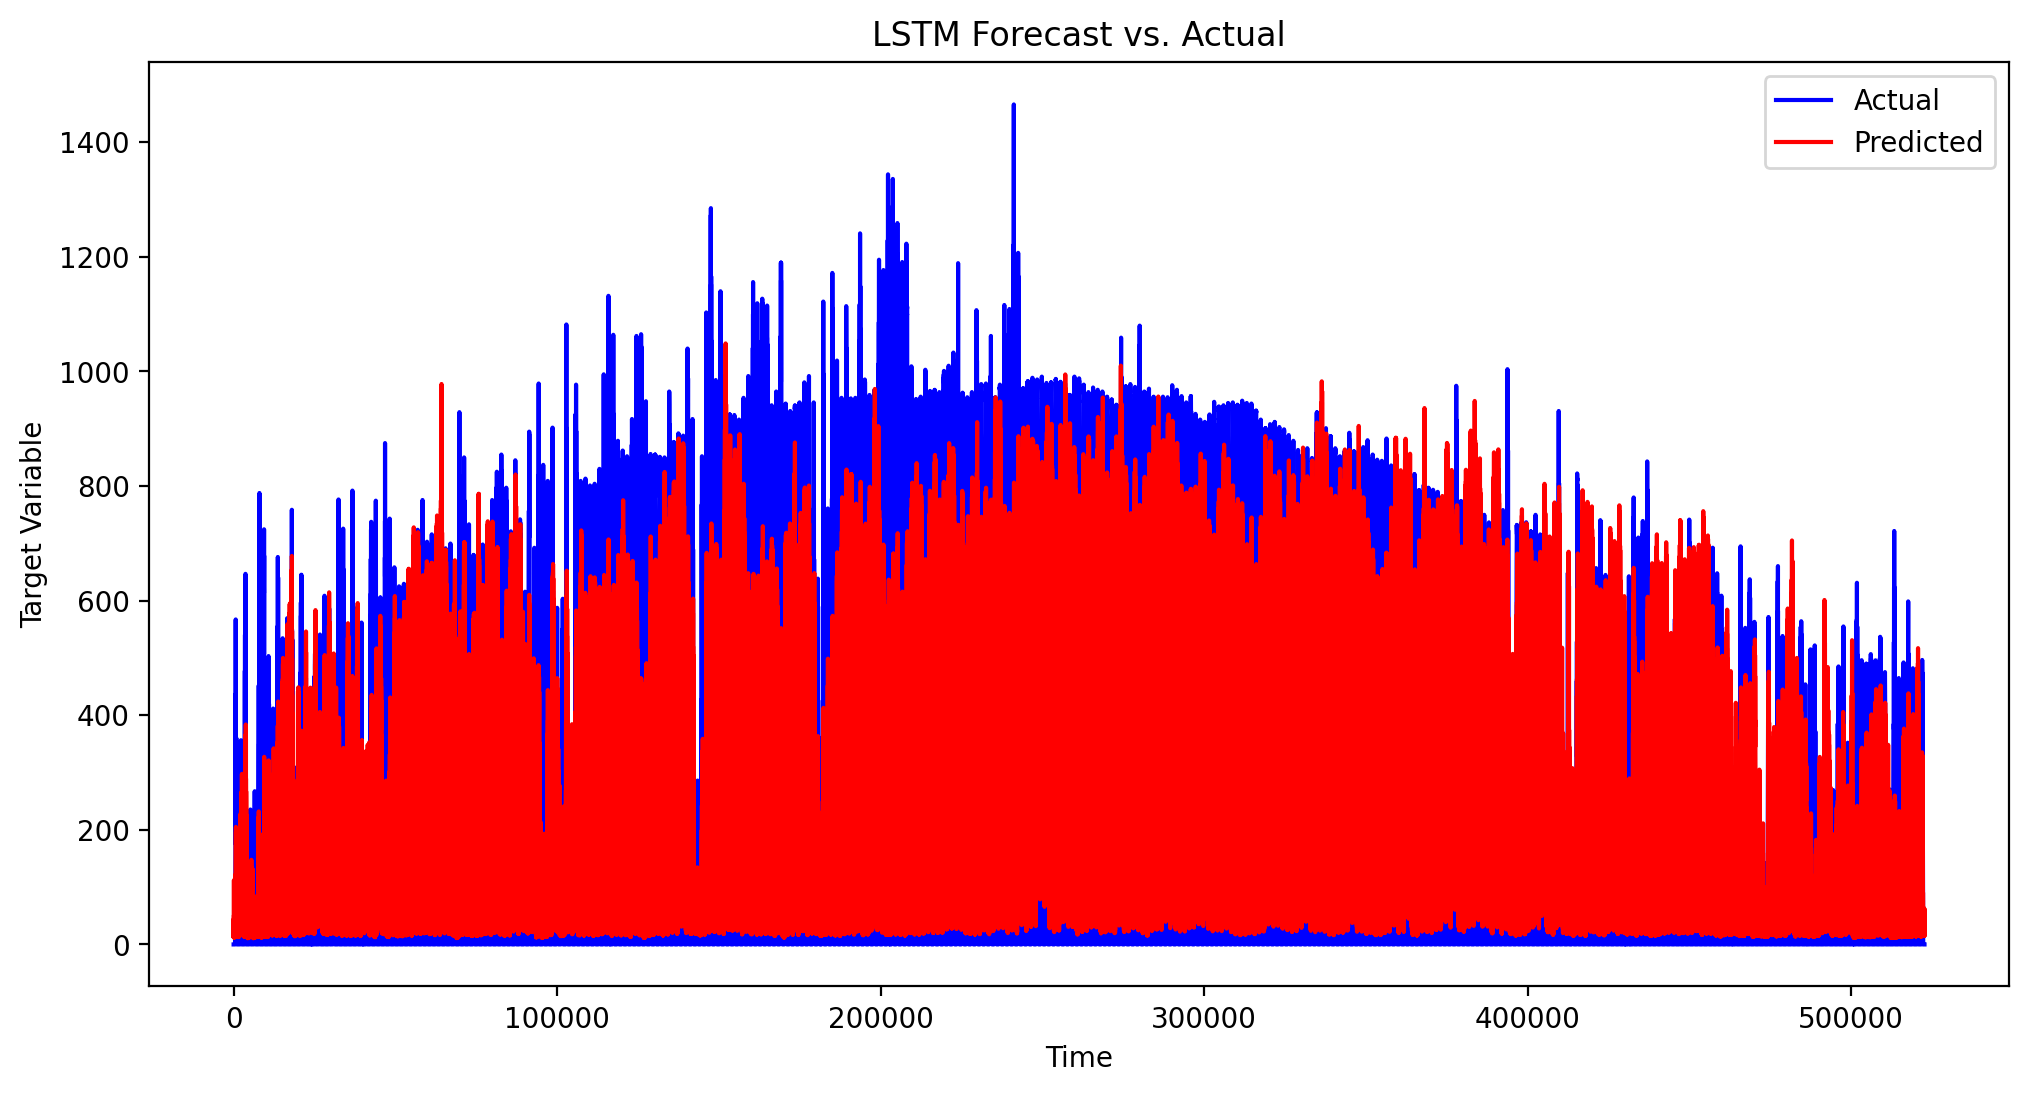

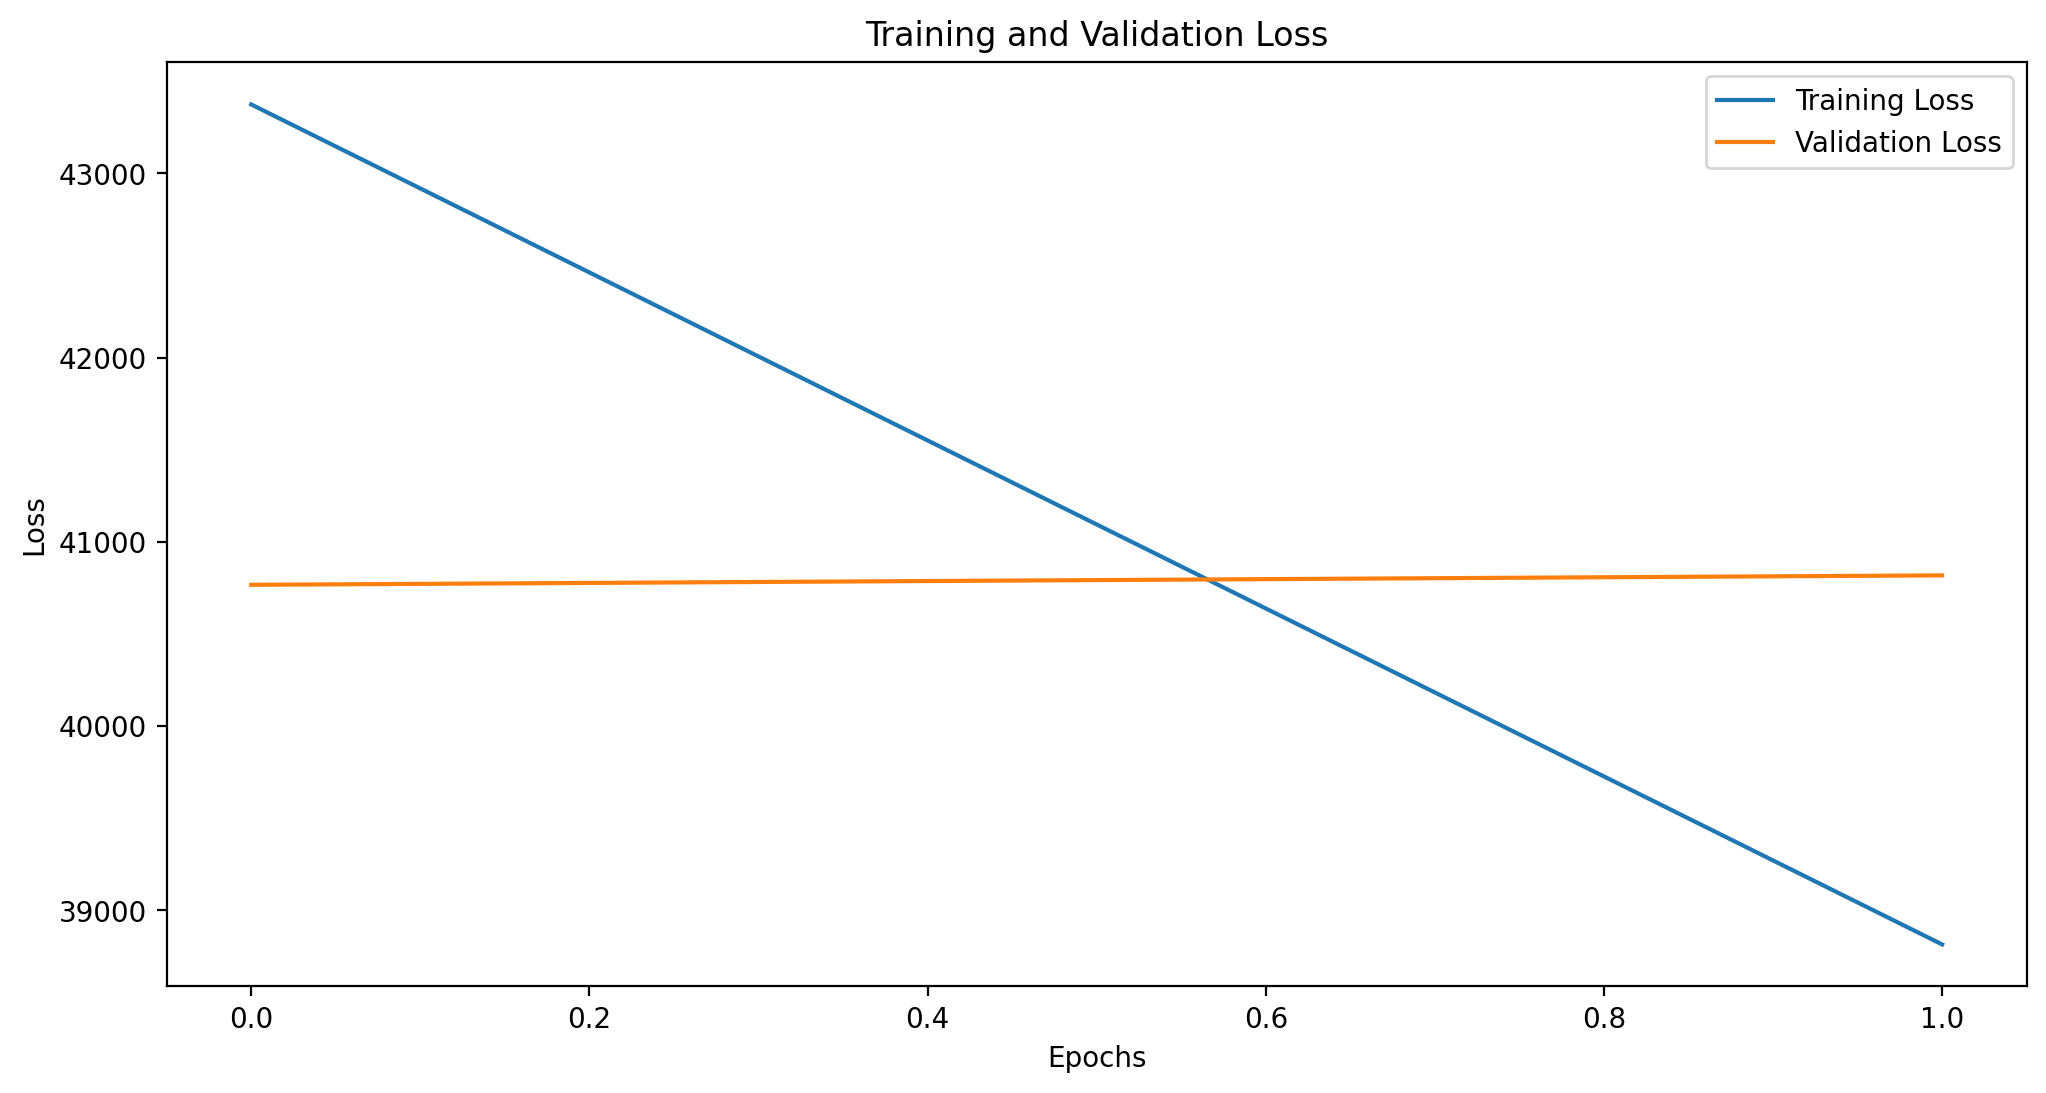

In [36]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Optionally, you can plot the actual vs. predicted values and training/validation loss
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='b')
plt.plot(y_pred, label='Predicted', color='r')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.title('LSTM Forecast vs. Actual')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Appendix

In [12]:
df_sky_img_features = pd.read_csv("../data/Folsom_sky_image_features.csv", infer_datetime_format=True)
df_sky_img_features = df_sky_img_features.rename(columns={"timestamp": "timeStamp"})
df_sky_img_features

,timeStamp,AVG(R),STD(R),ENT(R),AVG(G),STD(G),ENT(G),AVG(B),STD(B),ENT(B),AVG(RB),STD(RB),ENT(RB),AVG(NRB),STD(NRB),ENT(NRB)
0,2014-01-01 00:00:11,102.8933,45.8083,5.6373,121.5468,39.5426,5.6390,133.4322,30.8409,5.4275,0.7457,0.1647,4.8206,-0.1554,0.1033,4.2279
1,2014-01-01 00:01:10,109.1193,44.9516,5.6762,128.0568,38.7453,5.6535,139.4049,30.2546,5.4146,0.7601,0.1547,4.7120,-0.1447,0.0953,4.0961
2,2014-01-01 00:02:10,118.4310,44.4158,5.6386,129.2313,39.1756,5.6381,134.9957,30.8004,5.4368,0.8591,0.1453,4.7299,-0.0822,0.0821,3.9662
3,2014-01-01 00:03:11,108.0799,46.3934,5.6447,129.5778,39.5050,5.6392,142.6288,30.9485,5.4369,0.7347,0.1625,4.8007,-0.1626,0.1034,4.2324
4,2014-01-01 00:04:11,106.7813,45.5549,5.6539,126.3533,39.0664,5.6438,137.2983,30.4596,5.4168,0.7541,0.1613,4.7906,-0.1494,0.1003,4.1823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775911,2016-12-31 23:55:59,119.0850,58.5266,6.1185,120.1349,55.4199,6.0586,121.2516,46.8522,5.8533,0.9560,0.1625,4.8787,-0.0299,0.0901,4.0444
775912,2016-12-31 23:57:00,118.1933,59.0074,6.0942,119.7764,55.4268,6.0228,119.8126,46.1397,5.8002,0.9598,0.1788,5.0047,-0.0295,0.0987,4.1621
775913,2016-12-31 23:57:59,117.1289,59.2942,6.0814,119.1408,55.3043,6.0002,120.5959,45.5852,5.7543,0.9429,0.1899,5.0979,-0.0398,0.1066,4.2562
775914,2016-12-31 23:58:59,110.1486,61.0436,6.0823,116.9210,55.7548,6.0016,124.4827,45.2933,5.7811,0.8445,0.2123,5.1260,-0.0995,0.1323,4.4107


In [15]:
df_1 = df.merge(df_sky_img_features, on="timeStamp", how="left", indicator=True)

In [32]:
df_1["_merge"].value_counts()


left_only     1272457
both           279863
right_only          0
Name: _merge, dtype: int64